In [1]:
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp312-cp312-linux_x86_64.whl size=802214 sha256=2ef2f02f8bab7e5e0c11c7e25fc3fbbfb312e5148ea186d4bc3685b6fc3ae94e
  Stored in directory: /root/.cache/pip/wheels/2e/8f/d0/13408a84825c9a587151a74727b4a6d47ec67e0d625b385ad7
Successfully built torch-cluster


In [2]:
!pip install torch-scatter torch-sparse torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=664632 sha256=eb4f2ca31d2494188252d631b74bd06ff12f908edd6e38ae6dd592c4de5427cc
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1222874 sha256=e1ea87b256c162df4daf84bc181526663ffa56d84bf994e61fee5a8553cd1475
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2
Successfully built torch-scatte

In [3]:
!pip install egnn-pytorch

In [13]:
# Основные библиотеки
import os
import warnings
import numpy as np
import pandas as pd

# PyTorch и геометрические библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_scatter import scatter_mean

# для модели
from torch_geometric.nn.models import SchNet, DimeNetPlusPlus
from egnn_pytorch import EGNN_Network

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import umap

# Статистика и анализ
from scipy import stats
from scipy.stats import gaussian_kde, shapiro, probplot, ks_2samp
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# Скачиваем датасет и создаем сплиты train, validation и test

In [36]:
dataset = QM9(root='./data/QM9')

In [9]:
# Создадим Dataloader, нам нужно избавиться в колонке y от всех колонок кроме gap, который находится в индексе 4
processed_data = []

for data in dataset:
    data = data.clone()
    data.y = data.y[:, 4]  # Только HOMO-LUMO gap
    data.pos = data.pos - data.pos.mean(dim=0, keepdim=True)
    processed_data.append(data)

# Разделение в соотношении 0.8 : 0.1 : 0.1 <-> трейн : валидация : тест
dataset_size = len(processed_data)
indices = torch.randperm(dataset_size).tolist()

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = [processed_data[i] for i in train_indices]
val_dataset = [processed_data[i] for i in val_indices]
test_dataset = [processed_data[i] for i in test_indices]

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Посмотрим на один батч
for batch in train_loader:
    print("\nСтруктура батча от DataLoader:")
    print(f"Тип: {type(batch)}")
    print(f"Атрибуты: {batch.keys}")
    print(f"  x shape: {batch.x.shape}")  # Признаки атомов
    print(f"  edge_index shape: {batch.edge_index.shape}")  # Связи
    print(f"  edge_attr shape: {batch.edge_attr.shape}")  # Признаки связей
    print(f"  pos shape: {batch.pos.shape}")  # Координаты для EGNN
    print(f"  y shape: {batch.y.shape}")  # Таргеты: [batch_size]
    print(f"  batch tensor: {batch.batch[:20]}...")  # Принадлежность атомов к молекулам
    print(f"  Пример таргета: {batch.y[0].item():.4f} eV")
    break


Структура батча от DataLoader:
Тип: <class 'abc.DataBatch'>
Атрибуты: <bound method BaseData.keys of DataBatch(x=[563, 11], edge_index=[2, 1174], edge_attr=[1174, 4], y=[32], pos=[563, 3], idx=[32], name=[32], z=[563], batch=[563], ptr=[33])>
  x shape: torch.Size([563, 11])
  edge_index shape: torch.Size([2, 1174])
  edge_attr shape: torch.Size([1174, 4])
  pos shape: torch.Size([563, 3])
  y shape: torch.Size([32])
  batch tensor: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])...
  Пример таргета: 7.0423 eV


# Работа с данными - от простого к сложному

In [ ]:
print(dataset)
print(f"Dataset length: {len(dataset)}")

QM9(130831)
Dataset length: 130831


In [ ]:
# В колонке z у нас индексы атомов закодированных под каждым номером
dataset[30]['z']

tensor([6, 6, 6, 7, 1, 1, 1, 1, 1])

In [ ]:
# Тут у нас видимо полождение каждого атома как узла графа
dataset[30]['x']

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
# Здесь должно быть указание какие ребра существуют в нашем графе между вершинами
dataset[30]['edge_index']

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7, 8],
        [1, 4, 5, 6, 0, 2, 7, 8, 1, 3, 2, 0, 0, 0, 1, 1]])

In [ ]:
# Позиции атомов
dataset[30]['pos']

tensor([[-0.0252,  1.5477,  0.0213],
        [ 0.0118,  0.0100, -0.0156],
        [ 0.6892, -0.5084, -1.2033],
        [ 1.2257, -0.9036, -2.1474],
        [ 0.9857,  1.9621,  0.0237],
        [-0.5552,  1.9460, -0.8471],
        [-0.5396,  1.8829,  0.9254],
        [ 0.5248, -0.3823,  0.8693],
        [-1.0045, -0.3983,  0.0053]])

In [ ]:
# Сколько связей у атома в позиции
dataset[30]['edge_attr']

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
data = dataset[30]
for i in range(10):
  print(dataset[i])

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_2', z=[4])
Data(x=[3, 11], edge_index=[2, 4], edge_attr=[4, 4], y=[1, 19], pos=[3, 3], idx=[1], name='gdb_3', z=[3])
Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_4', z=[4])
Data(x=[3, 11], edge_index=[2, 4], edge_attr=[4, 4], y=[1, 19], pos=[3, 3], idx=[1], name='gdb_5', z=[3])
Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_6', z=[4])
Data(x=[8, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[8, 3], idx=[1], name='gdb_7', z=[8])
Data(x=[6, 11], edge_index=[2, 10], edge_attr=[10, 4], y=[1, 19], pos=[6, 3], idx=[1], name='gdb_8', z=[6])
Data(x=[7, 11], edge_index=[2, 12], edge_attr=[12, 4], y=[1, 19], pos=[7, 3], idx=[1], name='gdb_9', z=[7])
Data(x=[6, 11], edge_index=[2, 10], edge

In [ ]:
print(f"Target properties (data.y):\n{data.y}")
print(f"Shape of target properties: {data.y.shape}")

Target properties (data.y):
tensor([[ 3.9233e+00,  3.5380e+01, -8.7430e+00,  9.2519e-01,  9.6682e+00,
          3.1453e+02,  2.0188e+00, -4.6805e+03, -4.6804e+03, -4.6804e+03,
         -4.6813e+03,  1.4988e+01, -3.7568e+01, -3.7788e+01, -3.7993e+01,
         -3.5248e+01,  2.8002e+01,  4.6775e+00,  4.2176e+00]])
Shape of target properties: torch.Size([1, 19])


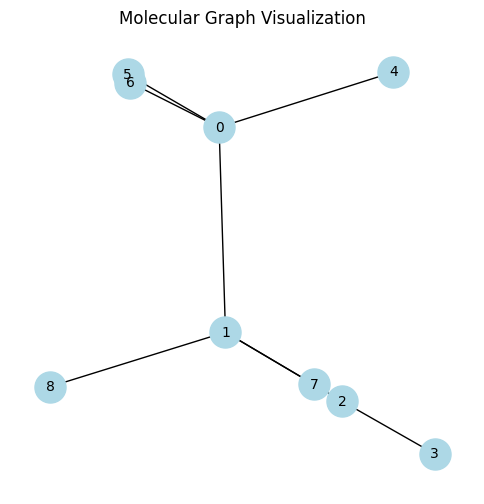

In [ ]:
# Нарисуем граф с помощью network
graph = nx.Graph()

# Добавляем вершины в позициях
for i in range(data.num_nodes):
    graph.add_node(i, pos=data.pos[i, :2].tolist())

# Добавляем ребра
# нужно проитерироваться через все пары (source, target)
edge_list = data.edge_index.t().tolist()
graph.add_edges_from(edge_list)

# Получаем позиции вершин для отрисовки
pos = nx.get_node_attributes(graph, 'pos')

# Рисуем
plt.figure(figsize=(6, 6))
nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Molecular Graph Visualization")
plt.axis('off') # Hide axes
plt.show()

ЗАПУСК ПОЛНОГО АНАЛИЗА ХИМИЧЕСКИХ ДАННЫХ

1. АНАЛИЗ АТОМНОГО СОСТАВА
----------------------------------------


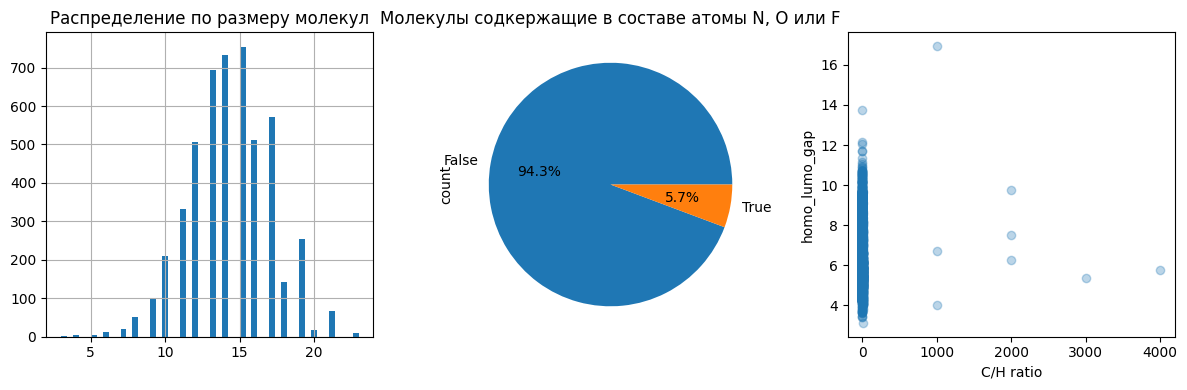


2. ХИМИЧЕСКОЕ РАЗНООБРАЗИЕ
----------------------------------------


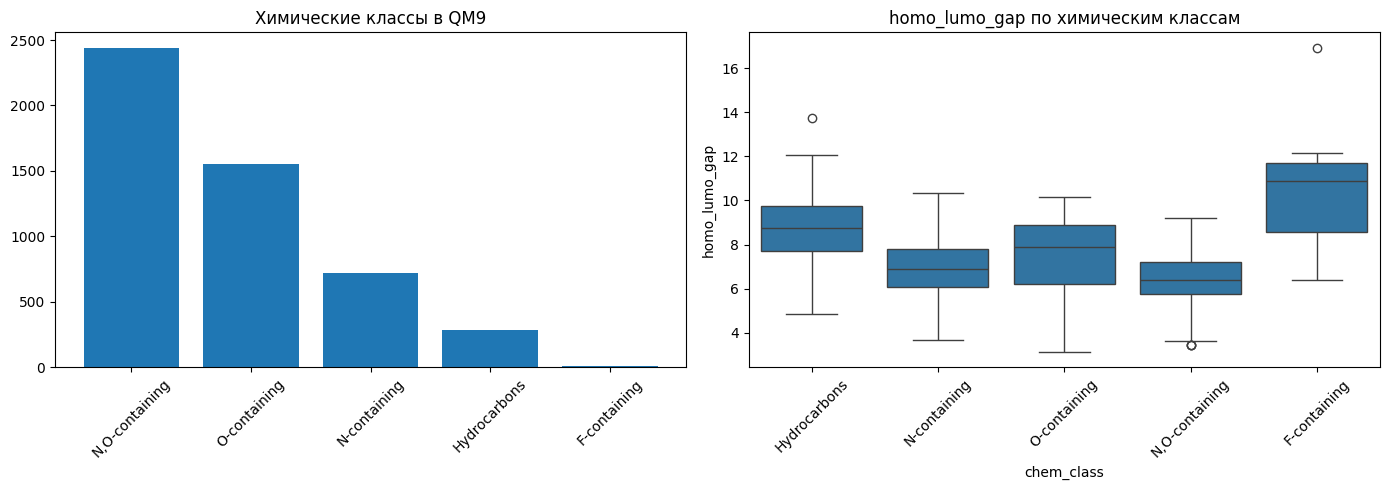


5. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
----------------------------------------
СТАТИСТИЧЕСКИЙ АНАЛИЗ HOMO-LUMO GAP
               Метрика     Значение
            Количество 5.000000e+03
               Среднее 7.004078e+00
               Медиана 6.790601e+00
Стандартное отклонение 1.404740e+00
               Минимум 3.132030e+00
              Максимум 1.692820e+01
       25-й перцентиль 6.016438e+00
       75-й перцентиль 8.079061e+00
Коэффициент асимметрии 3.061950e-01
  Коэффициент эксцесса 1.737448e-02
  Shapiro-Wilk p-value 7.204377e-24


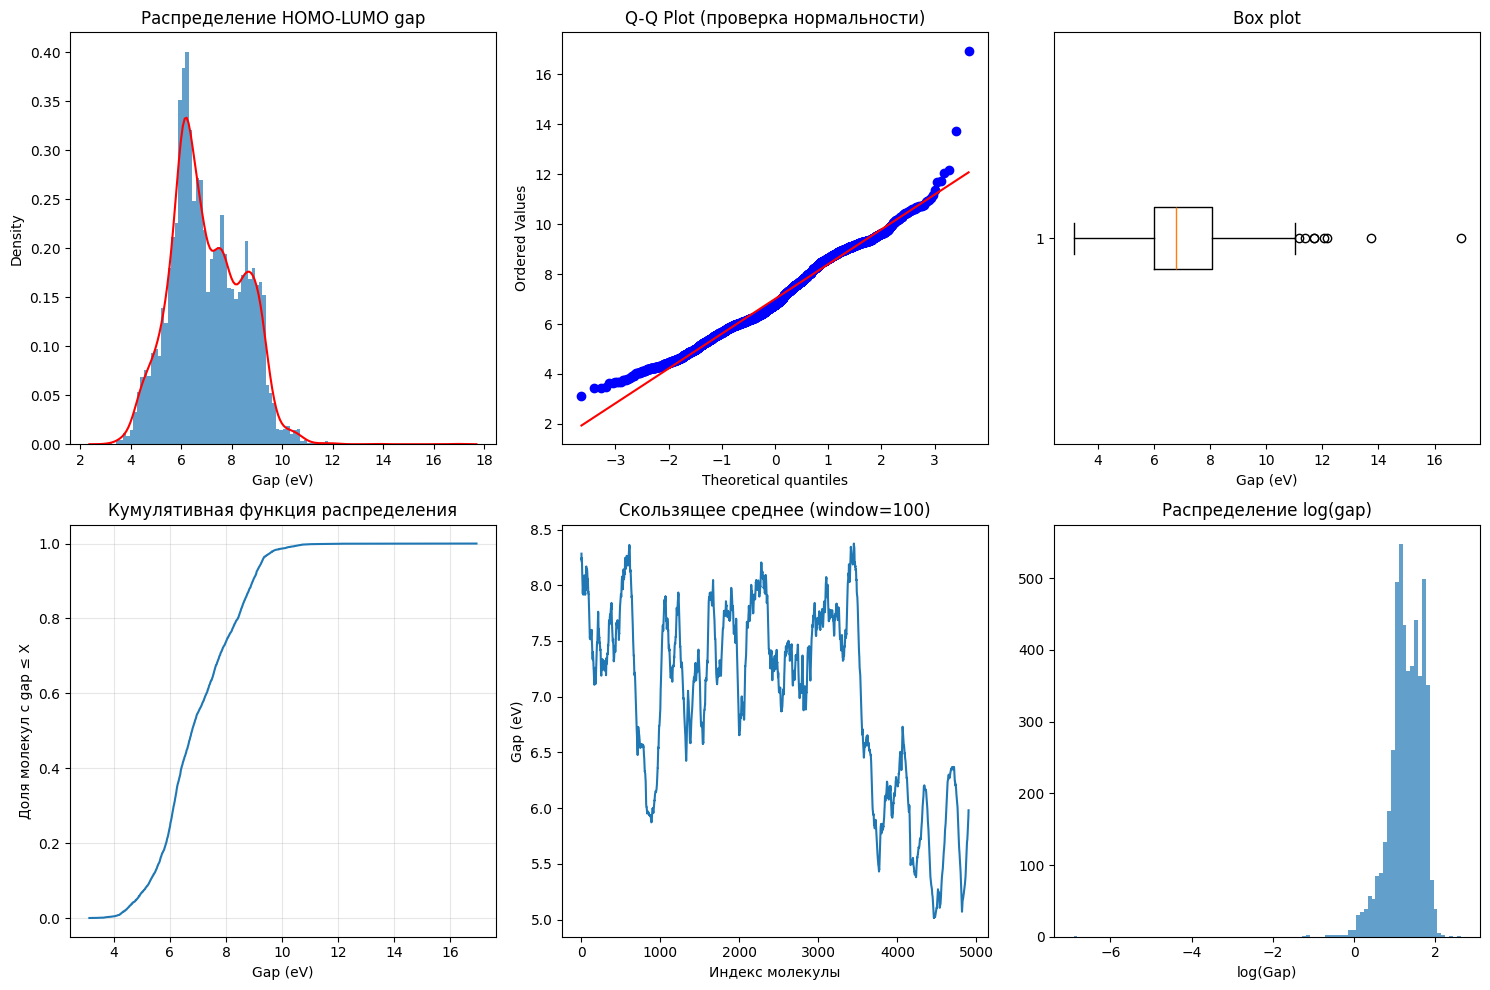

Распределение ОТЛИЧАЕТСЯ от нормального (p ≤ 0.05)
Распределение симметричное (|skewness| < 0.5)


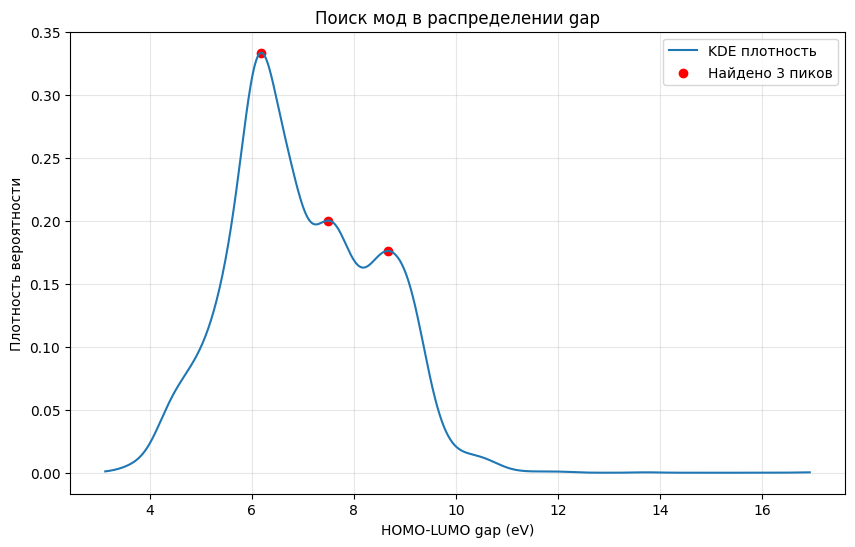

Обнаружено 3 мод (пиков)!
Это может означать разные классы молекул с характерными gap
  Мода 1: gap ≈ 6.184 эВ
  Мода 2: gap ≈ 7.496 эВ
  Мода 3: gap ≈ 8.670 эВ

6. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
----------------------------------------


<Figure size 800x800 with 0 Axes>

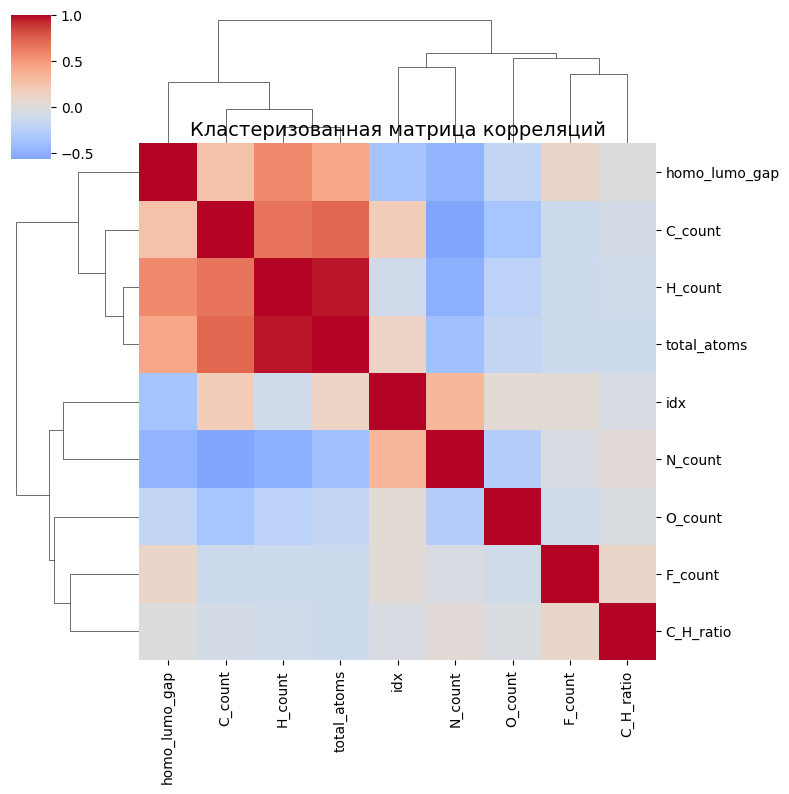


7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
----------------------------------------


<Figure size 800x600 with 0 Axes>

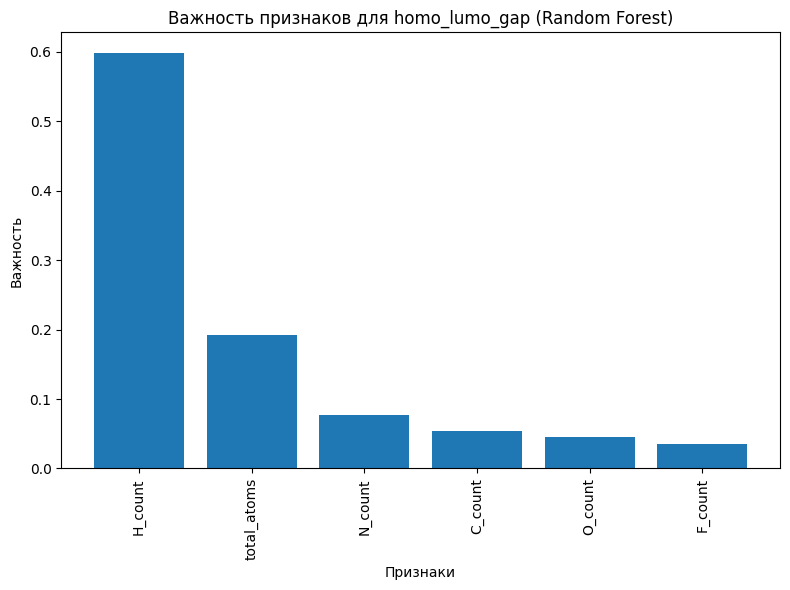

In [49]:
def analyze_composition(df, target_column='homo_lumo_gap'):
    formula_counts = df.groupby(['H_count', 'C_count', 'N_count', 'O_count', 'F_count']).size()

    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    df['total_atoms'].hist(bins=50)
    plt.title('Распределение по размеру молекул')

    plt.subplot(132)
    df['has_only_CH'] = (df['N_count'] + df['O_count'] + df['F_count']) == 0
    df['has_only_CH'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title('Молекулы содкержащие в составе атомы N, O или F')

    plt.subplot(133)
    df['C_H_ratio'] = df['C_count'] / (df['H_count'] + 0.001)
    plt.scatter(df['C_H_ratio'], df[target_column], alpha=0.3)
    plt.xlabel('C/H ratio')
    plt.ylabel(target_column)

    plt.tight_layout()
    plt.show()

def chemical_diversity_analysis(df, target_column='homo_lumo_gap'):
    conditions = [
        (df['O_count'] > 0) & (df['N_count'] == 0),
        (df['N_count'] > 0) & (df['O_count'] == 0),
        (df['F_count'] > 0),
        (df['O_count'] > 0) & (df['N_count'] > 0),
        (df['C_count'] == df['total_atoms'] - df['H_count']),
    ]

    choices = [
        'O-containing',
        'N-containing',
        'F-containing',
        'N,O-containing',
        'Hydrocarbons',
    ]

    df['chem_class'] = np.select(conditions, choices, default='Other')

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    class_counts = df['chem_class'].value_counts()
    axes[0].bar(range(len(class_counts)), class_counts.values)
    axes[0].set_xticks(range(len(class_counts)))
    axes[0].set_xticklabels(class_counts.index, rotation=45)
    axes[0].set_title('Химические классы в QM9')

    sns.boxplot(x='chem_class', y=target_column, data=df, ax=axes[1])
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_title(f'{target_column} по химическим классам')

    plt.tight_layout()
    plt.show()

    return df

def analyze_target_distribution(gap_values):
    print("="*60)
    print("СТАТИСТИЧЕСКИЙ АНАЛИЗ HOMO-LUMO GAP")
    print("="*60)

    stats_dict = {
        'Количество': len(gap_values),
        'Среднее': np.mean(gap_values),
        'Медиана': np.median(gap_values),
        'Стандартное отклонение': np.std(gap_values),
        'Минимум': np.min(gap_values),
        'Максимум': np.max(gap_values),
        '25-й перцентиль': np.percentile(gap_values, 25),
        '75-й перцентиль': np.percentile(gap_values, 75),
        'Коэффициент асимметрии': stats.skew(gap_values),
        'Коэффициент эксцесса': stats.kurtosis(gap_values),
    }

    shapiro_stat, shapiro_p = shapiro(gap_values[:min(5000, len(gap_values))])
    stats_dict['Shapiro-Wilk p-value'] = shapiro_p

    df_stats = pd.DataFrame(list(stats_dict.items()),
                           columns=['Метрика', 'Значение'])
    print(df_stats.to_string(index=False))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].hist(gap_values, bins=100, density=True, alpha=0.7)
    sns.kdeplot(gap_values, ax=axes[0,0], color='red')
    axes[0,0].set_title('Распределение HOMO-LUMO gap')
    axes[0,0].set_xlabel('Gap (eV)')

    probplot(gap_values, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot (проверка нормальности)')

    axes[0,2].boxplot(gap_values, vert=False)
    axes[0,2].set_title('Box plot')
    axes[0,2].set_xlabel('Gap (eV)')

    sorted_gaps = np.sort(gap_values)
    cumulative = np.arange(1, len(sorted_gaps)+1) / len(sorted_gaps)
    axes[1,0].plot(sorted_gaps, cumulative)
    axes[1,0].set_title('Кумулятивная функция распределения')
    axes[1,0].set_xlabel('Gap (eV)')
    axes[1,0].set_ylabel('Доля молекул с gap ≤ X')
    axes[1,0].grid(True, alpha=0.3)

    window_size = min(100, len(gap_values))
    if window_size > 10:
        rolling_mean = np.convolve(gap_values, np.ones(window_size)/window_size, mode='valid')
        axes[1,1].plot(rolling_mean)
        axes[1,1].set_title(f'Скользящее среднее (window={window_size})')
        axes[1,1].set_xlabel('Индекс молекулы')
        axes[1,1].set_ylabel('Gap (eV)')

    log_gaps = np.log(gap_values - gap_values.min() + 0.001)
    axes[1,2].hist(log_gaps, bins=100, alpha=0.7)
    axes[1,2].set_title('Распределение log(gap)')
    axes[1,2].set_xlabel('log(Gap)')

    plt.tight_layout()
    plt.show()

    if shapiro_p > 0.05:
        print("Распределение НЕ отличается от нормального (p > 0.05)")
    else:
        print("Распределение ОТЛИЧАЕТСЯ от нормального (p ≤ 0.05)")

    skewness = stats_dict['Коэффициент асимметрии']
    if abs(skewness) < 0.5:
        print("Распределение симметричное (|skewness| < 0.5)")
    elif skewness > 0:
        print("Распределение с правосторонней асимметрией (skewness > 0)")
    else:
        print("Распределение с левосторонней асимметрией (skewness < 0)")

def detect_multimodality(gap_values):
    kde = gaussian_kde(gap_values)
    x_grid = np.linspace(gap_values.min(), gap_values.max(), 1000)
    density = kde(x_grid)

    peaks, properties = find_peaks(density, prominence=0.001)

    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, density, label='KDE плотность')
    plt.scatter(x_grid[peaks], density[peaks], color='red',
                label=f'Найдено {len(peaks)} пиков')
    plt.xlabel('HOMO-LUMO gap (eV)')
    plt.ylabel('Плотность вероятности')
    plt.title('Поиск мод в распределении gap')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    if len(peaks) > 1:
        print(f"Обнаружено {len(peaks)} мод (пиков)!")
        print("Это может означать разные классы молекул с характерными gap")
        for i, peak_idx in enumerate(peaks):
            print(f"  Мода {i+1}: gap ≈ {x_grid[peak_idx]:.3f} эВ")
    else:
        print("Распределение унимодальное")

def correlation_network_analysis(df, target_column='homo_lumo_gap'):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(8, 8))
    g = sns.clustermap(corr_matrix,
                      cmap='coolwarm',
                      center=0,
                      annot=False,
                      fmt='.2f',
                      figsize=(8, 8))
    g.ax_heatmap.set_title('Кластеризованная матрица корреляций', fontsize=14)
    plt.show()

    plt.figure(figsize=(8, 6))
    G = nx.Graph()

    threshold = 0.3
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr = abs(corr_matrix.iloc[i, j])
            if corr > threshold:
                G.add_edge(corr_matrix.columns[i],
                          corr_matrix.columns[j],
                          weight=corr)

def feature_importance_for_gap(df, target_column='homo_lumo_gap'):
    X = df.select_dtypes(include=[np.number])
    columns_to_drop = [col for col in ['idx', 'chem_class', 'dominant_atom',
                 'size_category', 'quadrant', 'has_only_CH', 'C_H_ratio',
                 'compactness'] if col in X.columns]

    if target_column in X.columns:
        y = X[target_column]
        X = X.drop(columns=[target_column] + columns_to_drop, errors='ignore')
    else:
        print(f"Ошибка: целевая переменная {target_column} не найдена")
        return

    if X.shape[1] == 0:
        print("Нет признаков для анализа важности")
        return

    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.title(f"Важность признаков для {target_column} (Random Forest)")
    plt.bar(range(min(20, X.shape[1])), importances[indices[:20]])
    plt.xticks(range(min(20, X.shape[1])), X.columns[indices[:20]], rotation=90)
    plt.xlabel("Признаки")
    plt.ylabel("Важность")
    plt.tight_layout()
    plt.show()

def run_full_analysis(df, target_column='homo_lumo_gap'):
    print("=" * 60)
    print("ЗАПУСК ПОЛНОГО АНАЛИЗА ХИМИЧЕСКИХ ДАННЫХ")
    print("=" * 60)

    print("\n1. АНАЛИЗ АТОМНОГО СОСТАВА")
    print("-" * 40)
    formula_counts = analyze_composition(df, target_column)

    print("\n2. ХИМИЧЕСКОЕ РАЗНООБРАЗИЕ")
    print("-" * 40)
    df = chemical_diversity_analysis(df, target_column)

    print("\n5. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
    print("-" * 40)
    if target_column in df.columns:
        analyze_target_distribution(df[target_column].values)
        detect_multimodality(df[target_column].values)

    print("\n6. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
    print("-" * 40)
    correlation_network_analysis(df, target_column)

    print("\n7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
    print("-" * 40)
    feature_importance_for_gap(df, target_column)

    return df
def create_df_from_qm9(dataset, n_molecules=5000):
    data_list = []
    for i in range(min(n_molecules, len(dataset))):
        data = dataset[i]
        z = data.z.numpy()
        record = {
            'idx': i,
            'H_count': np.sum(z == 1),
            'C_count': np.sum(z == 6),
            'N_count': np.sum(z == 7),
            'O_count': np.sum(z == 8),
            'F_count': np.sum(z == 9),
            'total_atoms': len(z),
            'homo_lumo_gap': data.y[0, 4].item(),  # gap
        }
        data_list.append(record)
    return pd.DataFrame(data_list)
if __name__ == "__main__":
    df = create_df_from_qm9(dataset)
    run_full_analysis(df, 'homo_lumo_gap')


In [ ]:
def inspect_molecule(data, molecule_index=None):
    """Детальный обзор данных"""

    if molecule_index is not None:
        data = dataset[molecule_index]

    # Основная информация
    print(f"\n1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
    print(f"   Индекс в датасете: {data.idx.item() if hasattr(data, 'idx') else 'N/A'}")
    print(f"   Имя: {data.name if hasattr(data, 'name') else 'N/A'}")
    print(f"   Количество атомов: {data.num_nodes}")
    print(f"   Количество ребер: {data.num_edges}")

    # Атомные данные
    print(f"\n2. АТОМНЫЕ ДАННЫЕ:")
    print(f"   z (атомные номера) [форма: {data.z.shape}]:")
    print(f"   {data.z.tolist()}")

    # Расшифровка атомных номеров
    atomic_symbols = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    atom_counts = {}
    for atom_num in data.z:
        symbol = atomic_symbols.get(atom_num.item(), f'Unknown({atom_num})')
        atom_counts[symbol] = atom_counts.get(symbol, 0) + 1

    print(f"   Состав молекулы: {dict(atom_counts)}")

    print(f"\n   pos (координаты) [форма: {data.pos.shape}]:")
    for i, (x, y, z) in enumerate(data.pos):
        print(f"     Атом {i+1} ({atomic_symbols.get(data.z[i].item(), '?')}): x={x:10.6f}, y={y:10.6f}, z={z:10.6f}")

    print(f"\n   x (признаки узлов) [форма: {data.x.shape}]:")
    print(f"   Первые 5 строк:")
    for i in range(min(5, len(data.x))):
        print(f"     Атом {i+1}: {data.x[i].tolist()}")

    # Ребра и их атрибуты
    print(f"\n3. РЕБРА И СВЯЗИ:")
    print(f"   edge_index [форма: {data.edge_index.shape}]:")
    print(f"   {data.edge_index.t()}")

    print(f"\n   edge_attr (атрибуты ребер) [форма: {data.edge_attr.shape}]:")
    print(f"   Первые 5 ребер:")
    for i in range(min(5, len(data.edge_attr))):
        src, dst = data.edge_index[:, i]
        src_atom = atomic_symbols.get(data.z[src].item(), '?')
        dst_atom = atomic_symbols.get(data.z[dst].item(), '?')
        print(f"     Ребро {i}: {src.item()} ({src_atom}) → {dst.item()} ({dst_atom}) : {data.edge_attr[i].tolist()}")

    # Целевые свойства (19 свойств)
    print(f"\n4. ЦЕЛЕВЫЕ СВОЙСТВА (data.y доступно по ссылке https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.datasets.QM9.html) [форма: {data.y.shape}]:")

    # Определения свойств QM9
    property_names = [
        (0, 'mu', 'Дипольный момент [D]'),
        (1, 'alpha', 'Поляризуемость [a0^3]'),
        (2, 'HOMO', 'Энергия HOMO [eV]'),
        (3, 'LUMO', 'Энергия LUMO [eV]'),
        (4, 'gap', 'HOMO-LUMO gap [eV]'),
        (5, 'R2', 'Квадрат дипольного момента [a0^2]'),
        (6, 'ZPVE', 'Нулевая колебательная энергия [eV]'),
        (7, 'U0', 'Внутренняя энергия при 0K [eV]'),
        (8, 'U', 'Внутренняя энергия при 298.15K [eV]'),
        (9, 'H', 'Энтальпия при 298.15K [eV]'),
        (10, 'G', 'Свободная энергия Гиббса при 298.15K [eV]'),
        (11, 'Cv', 'Теплоемкость при постоянном объеме при 298.15K [cal/(mol·K)]'),
        (12, 'U0_atom', 'Атомная энергия U0 (Atomization energy at 0K)'),
        (13, 'U_atom', 'Атомная энергия U_ATOM (Atomization energy at 298.15K)'),
        (14, 'H_atom', 'Атомная энтальпия H_ATOM (Atomization enthalpy at 298.15K)'),
        (15, 'G_atom', 'Атомная свободная энергия Гиббса G?'),
        (16, 'vib_freq_1', 'Вращательная константа  1'),
        (17, 'vib_freq_2', 'Вращательная константа 2'),
        (18, 'vib_freq_3', 'Вращательная константа 3')
    ]

    for idx, name, description in property_names:
        if idx < data.y.shape[1]:
            value = data.y[0, idx].item()
            print(f"   [{idx:2d}] {name:10}: {value:12.6f}  # {description}")

    return data

# Используем функцию для 30-й молекулы
mol_data = inspect_molecule(dataset[30])


1. ОСНОВНАЯ ИНФОРМАЦИЯ:
   Индекс в датасете: 30
   Имя: gdb_31
   Количество атомов: 9
   Количество ребер: 16

2. АТОМНЫЕ ДАННЫЕ:
   z (атомные номера) [форма: torch.Size([9])]:
   [6, 6, 6, 7, 1, 1, 1, 1, 1]
   Состав молекулы: {'C': 3, 'N': 1, 'H': 5}

   pos (координаты) [форма: torch.Size([9, 3])]:
     Атом 1 (C): x= -0.025200, y=  1.547700, z=  0.021300
     Атом 2 (C): x=  0.011800, y=  0.010000, z= -0.015600
     Атом 3 (C): x=  0.689200, y= -0.508400, z= -1.203300
     Атом 4 (N): x=  1.225700, y= -0.903600, z= -2.147400
     Атом 5 (H): x=  0.985700, y=  1.962100, z=  0.023700
     Атом 6 (H): x= -0.555200, y=  1.946000, z= -0.847100
     Атом 7 (H): x= -0.539600, y=  1.882900, z=  0.925400
     Атом 8 (H): x=  0.524800, y= -0.382300, z=  0.869300
     Атом 9 (H): x= -1.004500, y= -0.398300, z=  0.005300

   x (признаки узлов) [форма: torch.Size([9, 11])]:
   Первые 5 строк:
     Атом 1: [0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 3.0]
     Атом 2: [0.0, 1.0, 0.0, 0

In [ ]:
def check_gap_values(num_molecules=50):
    """Проверка значений gap для нескольких молекул"""
    print("ПРОВЕРКА ЗНАЧЕНИЙ gap")
    print("=" * 60)

    print(f"{'Индекс':>8} {'Имя':>10} {'Атомы':>8} {'gap (eV)':>12} {'gap (Hartree)':>15}")
    print("-" * 60)

    for i in range(min(num_molecules, len(dataset))):
        data = dataset[i]
        gap_ev = data.y[0, 4].item()
        gap_hartree = gap_ev * 0.03675

        # Состав
        atomic_symbols = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
        composition = {}
        for atom_num in data.z:
            symbol = atomic_symbols.get(atom_num.item(), '?')
            composition[symbol] = composition.get(symbol, 0) + 1

        formula = ''.join([f"{symbol}{count}" for symbol, count in composition.items()])

        print(f"{i:8d} {data.name:>10} {formula:>8} {gap_ev:12.4f} {gap_hartree:15.6f}")

# Проверим первые 20 молекул
check_gap_values(20)

ПРОВЕРКА ЗНАЧЕНИЙ gap
  Индекс        Имя    Атомы     gap (eV)   gap (Hartree)
------------------------------------------------------------
       0      gdb_1     C1H4      13.7363        0.504809
       1      gdb_2     N1H3       9.2491        0.339906
       2      gdb_3     O1H2       9.8369        0.361507
       3      gdb_4     C2H2       9.1185        0.335106
       4      gdb_5   C1N1H1      10.3294        0.379607
       5      gdb_6   C1O1H2       6.1579        0.226304
       6      gdb_7     C2H6      12.0438        0.442608
       7      gdb_8   C1O1H4       9.3526        0.343706
       8      gdb_9     C3H4       8.7675        0.322206
       9     gdb_10   C2N1H3       9.9049        0.364007
      10     gdb_11   C2O1H4       6.3729        0.234204
      11     gdb_12 N1C1O1H3       7.7416        0.284505
      12     gdb_13     C3H8      11.3716        0.417908
      13     gdb_14   C2O1H6       9.2981        0.341706
      14     gdb_15   C2O1H6       9.3471      

### Проведем анализ данных и UMAP тренеровочного датасета

АНАЛИЗ ДАННЫХ QM9 НА ОСНОВЕ ИСХОДНЫХ СВОЙСТВ МОЛЕКУЛ
 Извлечение базовых признаков молекул...
 Извлечено 104664 молекул
 Признаков на молекулу: 17
 Диапазон HOMO-LUMO gap: [0.669, 16.928] эВ
  Приготовлено 10 признаков для UMAP
  Форма матрицы: (104664, 10)

 Запуск UMAP...
  n_components=2, n_neighbors=20, min_dist=0.2
  UMAP завершен
  Диапазон координат: X[-16.21, 16.40], Y[-8.42, 26.19]

 Визуализация результатов...


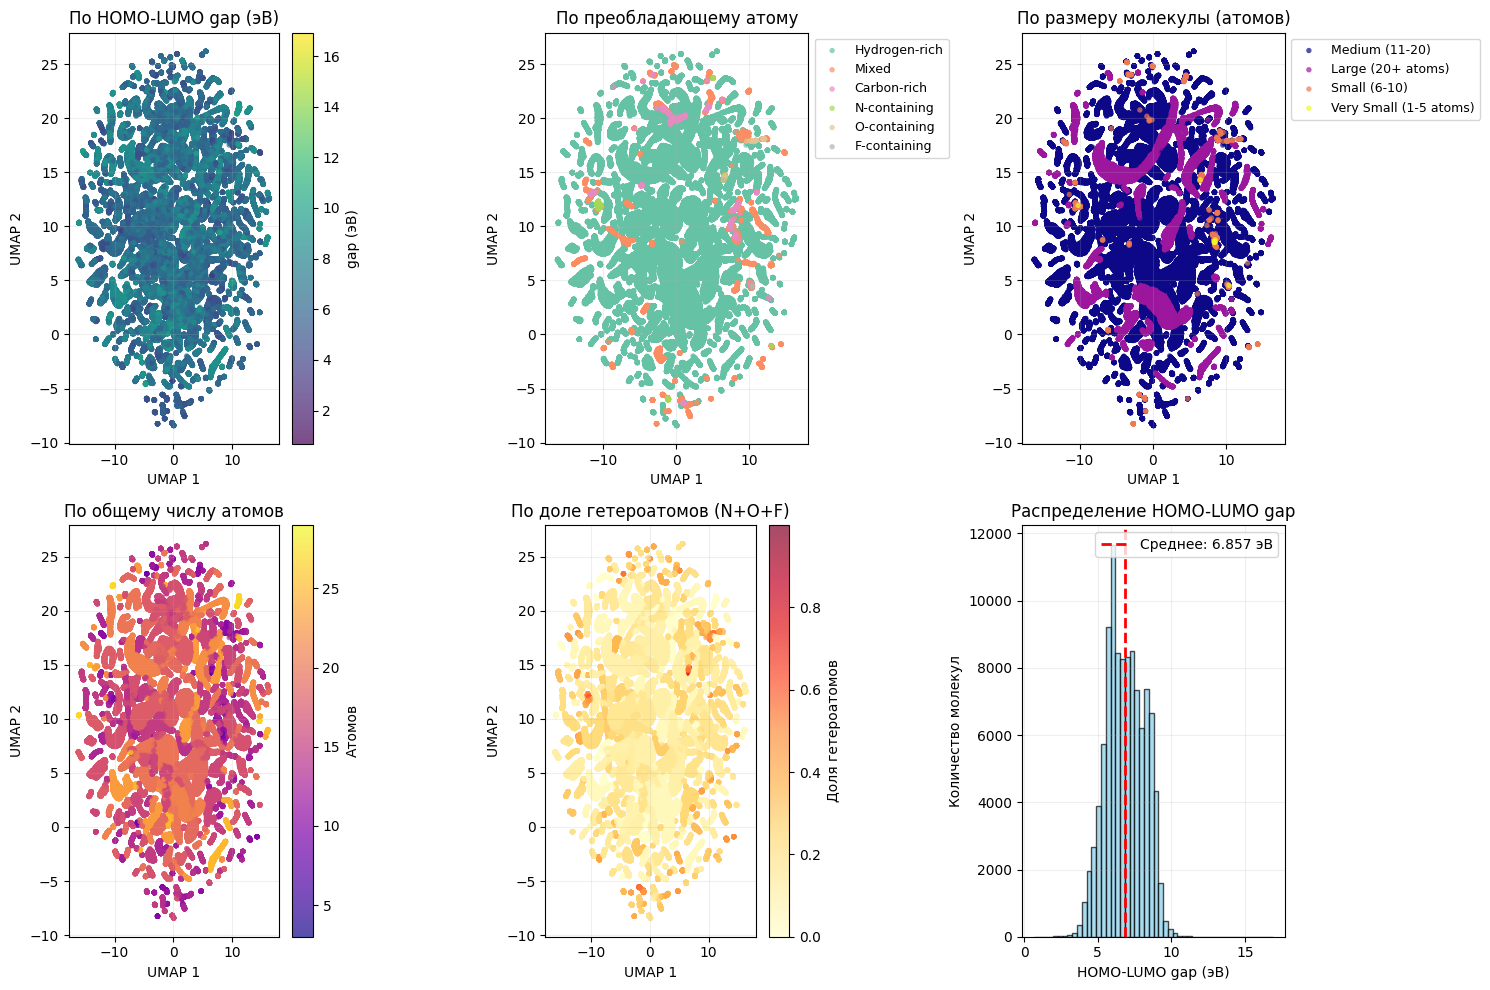

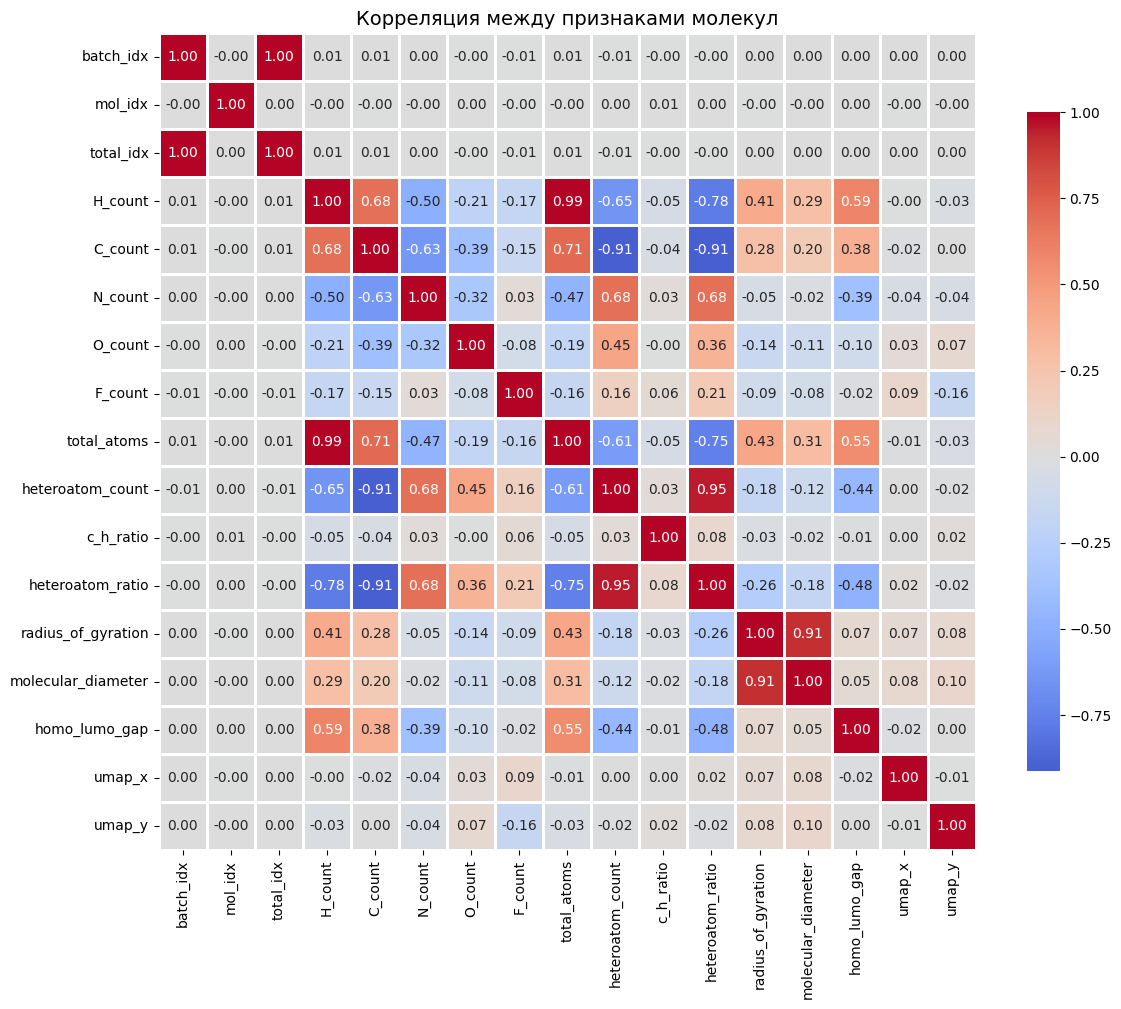

✓ Визуализация завершена

 Анализ кластеров на UMAP карте...

Статистика по квадрантам UMAP:
         homo_lumo_gap               total_atoms heteroatom_ratio C_count  \
                  mean    std  count        mean             mean    mean   
quadrant                                                                    
Q1               6.873  1.337  26287      18.031            0.149   6.296   
Q2               6.881  1.259  26045      17.811            0.145   6.356   
Q3               6.875  1.264  26287      18.117            0.147   6.355   
Q4               6.800  1.269  26045      18.151            0.143   6.433   

          dominant_atom  
               <lambda>  
quadrant                 
Q1        Hydrogen-rich  
Q2        Hydrogen-rich  
Q3        Hydrogen-rich  
Q4        Hydrogen-rich  


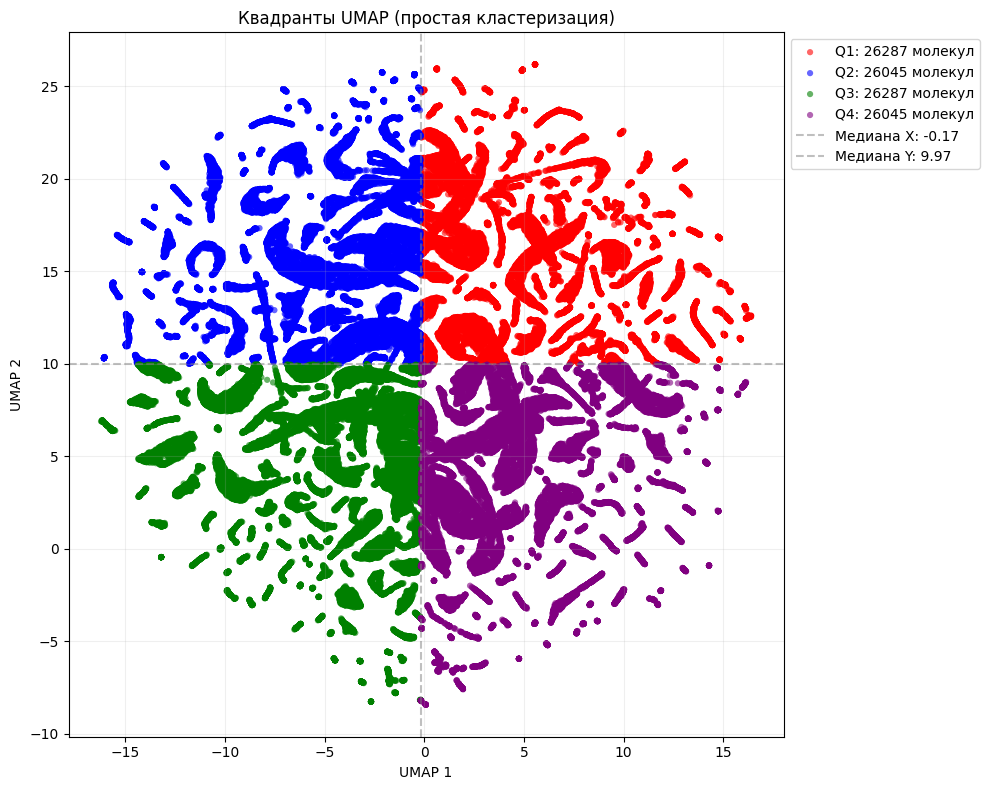


 Поиск интересных молекул (5 примеров)...

Молекулы с НАИБОЛЬШИМ HOMO-LUMO gap:
  Молекула 2516: gap=16.928 эВ, атомы: 5, состав: H0C1N0O0F4
  Молекула 57212: gap=13.736 эВ, атомы: 5, состав: H4C1N0O0F0
  Молекула 11775: gap=13.067 эВ, атомы: 8, состав: H0C2N0O0F6
  Молекула 45073: gap=12.572 эВ, атомы: 11, состав: H2C3N0O0F6
  Молекула 71651: gap=12.150 эВ, атомы: 11, состав: H5C3N0O0F3

Молекулы с НАИМЕНЬШИМ HOMO-LUMO gap:
  Молекула 31759: gap=0.669 эВ, атомы: 22, состав: H13C6N1O2F0
  Молекула 36008: gap=1.143 эВ, атомы: 19, состав: H10C5N2O2F0
  Молекула 74668: gap=1.143 эВ, атомы: 19, состав: H10C5N2O2F0
  Молекула 68068: gap=1.314 эВ, атомы: 22, состав: H13C6N1O2F0
  Молекула 102481: gap=1.695 эВ, атомы: 17, состав: H8C5N2O2F0

САМЫЕ БОЛЬШИЕ молекулы (по числу атомов):
  Молекула 1892: 29 атомов, gap=9.929 эВ
  Молекула 12899: 29 атомов, gap=10.014 эВ
  Молекула 15197: 29 атомов, gap=10.161 эВ
  Молекула 21393: 29 атомов, gap=9.913 эВ
  Молекула 21655: 29 атомов, gap=9.943 эВ



In [52]:
# Для 3D
from mpl_toolkits.mplot3d import Axes3D

class QM9_Data_Analyzer:
    """
    Анализатор данных QM9 на основе ИСХОДНЫХ свойств молекул
    """
    def __init__(self, data_loader):
        """
        Инициализация с загрузчиком данных QM9
        """
        self.data_loader = data_loader
        self.df_molecules = None  # Таблица с признаками молекул
        self.features = None      # Матрица признаков для UMAP
        self.targets = None       # Значения HOMO-LUMO gap

    def extract_basic_features(self):
        """
        Извлекаем БАЗОВЫЕ ПРИЗНАКИ из исходных данных молекул
        """
        print(" Извлечение базовых признаков молекул...")

        molecules_data = []

        for batch_idx, batch in enumerate(self.data_loader):
            # Для каждой молекулы в батче
            for mol_idx in range(batch.num_graphs):
                # Маска для атомов текущей молекулы
                mask = batch.batch == mol_idx

                # 1. АТОМНЫЙ СОСТАВ
                atom_numbers = batch.z[mask].cpu().numpy()

                # Подсчет атомов каждого типа
                h_count = np.sum(atom_numbers == 1)  # Водород
                c_count = np.sum(atom_numbers == 6)  # Углерод
                n_count = np.sum(atom_numbers == 7)  # Азот
                o_count = np.sum(atom_numbers == 8)  # Кислород
                f_count = np.sum(atom_numbers == 9)  # Фтор
                total_atoms = len(atom_numbers)

                # ПРОСТЫЕ ХИМИЧЕСКИЕ ПРИЗНАКИ
                heteroatom_count = n_count + o_count + f_count  # Гетероатомы (не C и H)
                c_h_ratio = c_count / (h_count + 1e-6)  # Отношение C/H (+1e-6 чтобы избежать деления на 0)
                heteroatom_ratio = heteroatom_count / (total_atoms + 1e-6)

                # ПРОСТЫЕ ГЕОМЕТРИЧЕСКИЕ ПРИЗНАКИ (из 3D координат)
                coords = batch.pos[mask].cpu().numpy()

                # Центр масс (простой центр)
                center = np.mean(coords, axis=0)

                # Радиус инерции (размер молекулы)
                distances_from_center = np.linalg.norm(coords - center, axis=1)
                radius_of_gyration = np.sqrt(np.mean(distances_from_center ** 2))

                # Молекулярный "диаметр" (максимальное расстояние между атомами)
                if total_atoms > 1:
                    # Для скорости берем подвыборку для больших молекул
                    max_sample = min(50, total_atoms)
                    indices = np.random.choice(total_atoms, max_sample, replace=False)
                    sampled_coords = coords[indices]

                    # Вычисляем попарные расстояния
                    molecular_diameter = 0
                    for i in range(len(sampled_coords)):
                        for j in range(i+1, len(sampled_coords)):
                            dist = np.linalg.norm(sampled_coords[i] - sampled_coords[j])
                            if dist > molecular_diameter:
                                molecular_diameter = dist
                else:
                    molecular_diameter = 0

                # Признаки связей - не будем считать
                if hasattr(batch, 'edge_index'):
                    # Это сложнее, так как edge_index для всего батча
                    bond_count = 0
                else:
                    bond_count = 0

                # ЦЕЛЕВОЕ СВОЙСТВО
                if hasattr(batch, 'y'):
                    if batch.y.dim() == 1:
                        gap_value = batch.y[mol_idx].item()
                    elif batch.y.dim() == 2:
                        gap_value = batch.y[mol_idx, 4].item()
                    else:
                        gap_value = 0
                else:
                    gap_value = 0

                # Собираем все признаки в словарь
                mol_features = {
                    # Идентификаторы
                    'batch_idx': batch_idx,
                    'mol_idx': mol_idx,
                    'total_idx': len(molecules_data),

                    # Атомный состав
                    'H_count': h_count,
                    'C_count': c_count,
                    'N_count': n_count,
                    'O_count': o_count,
                    'F_count': f_count,
                    'total_atoms': total_atoms,

                    # Химические признаки
                    'heteroatom_count': heteroatom_count,
                    'c_h_ratio': c_h_ratio,
                    'heteroatom_ratio': heteroatom_ratio,

                    # Геометрические признаки
                    'radius_of_gyration': radius_of_gyration,
                    'molecular_diameter': molecular_diameter,

                    # Целевое свойство
                    'homo_lumo_gap': gap_value,

                    # Простые категории для цветов на графиках
                    'dominant_atom': self._get_dominant_atom(h_count, c_count, n_count, o_count, f_count),
                    'size_category': self._get_size_category(total_atoms),
                }

                molecules_data.append(mol_features)


        # Создаем DataFrame
        self.df_molecules = pd.DataFrame(molecules_data)

        print(f" Извлечено {len(self.df_molecules)} молекул")
        print(f" Признаков на молекулу: {len(self.df_molecules.columns)}")
        print(f" Диапазон HOMO-LUMO gap: [{self.df_molecules['homo_lumo_gap'].min():.3f}, "
              f"{self.df_molecules['homo_lumo_gap'].max():.3f}] эВ")

        return self.df_molecules

    def _get_dominant_atom(self, h, c, n, o, f):
        """Определяем преобладающий атом для категоризации"""
        counts = {'H': h, 'C': c, 'N': n, 'O': o, 'F': f}
        max_atom = max(counts, key=counts.get)

        # Если углерод доминирует сильно
        if max_atom == 'C' and c > (h + n + o + f):
            return 'Carbon-rich'
        elif max_atom == 'H':
            return 'Hydrogen-rich'
        elif max_atom in ['N', 'O', 'F']:
            return f'{max_atom}-containing'
        else:
            return 'Mixed'

    def _get_size_category(self, total_atoms):
        """Категория по размеру молекулы"""
        if total_atoms <= 5:
            return 'Very Small (1-5 atoms)'
        elif total_atoms <= 10:
            return 'Small (6-10)'
        elif total_atoms <= 20:
            return 'Medium (11-20)'
        else:
            return 'Large (20+ atoms)'

    def prepare_features_for_umap(self):
        """
        Подготавливаем признаки для UMAP
        """
        if self.df_molecules is None:
            print("Сначала запустите extract_basic_features()!")
            return None

        # Выбираем числовые признаки для UMAP
        feature_columns = [
            # Атомные счетчики
            'H_count', 'C_count', 'N_count', 'O_count', 'F_count', 'total_atoms',

            # Химические отношения
            'c_h_ratio', 'heteroatom_ratio',

            # Геометрические
            'radius_of_gyration', 'molecular_diameter',
        ]

        # Создаем матрицу признаков
        self.features = self.df_molecules[feature_columns].values
        self.targets = self.df_molecules['homo_lumo_gap'].values

        # Нормализуем признаки
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(self.features)

        print(f"  Приготовлено {self.features.shape[1]} признаков для UMAP")
        print(f"  Форма матрицы: {self.features.shape}")

        return self.features_scaled

    def run_umap(self, n_components=2, n_neighbors=20, min_dist=0.1):
        """
        Запускаем UMAP на признаках молекул
        """
        if self.features_scaled is None:
            print("Сначала запустите prepare_features_for_umap()!")
            return None

        print(f"\n Запуск UMAP...")
        print(f"  n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}")

        # Создаем и обучаем UMAP
        umap_reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric='euclidean',
            random_state=42,
            n_jobs=-1
        )

        self.umap_result = umap_reducer.fit_transform(self.features_scaled)

        # Добавляем результаты UMAP в DataFrame
        if n_components == 2:
            self.df_molecules['umap_x'] = self.umap_result[:, 0]
            self.df_molecules['umap_y'] = self.umap_result[:, 1]
        elif n_components == 3:
            self.df_molecules['umap_x'] = self.umap_result[:, 0]
            self.df_molecules['umap_y'] = self.umap_result[:, 1]
            self.df_molecules['umap_z'] = self.umap_result[:, 2]

        print(f"  UMAP завершен")
        print(f"  Диапазон координат: X[{self.umap_result[:,0].min():.2f}, {self.umap_result[:,0].max():.2f}], "
              f"Y[{self.umap_result[:,1].min():.2f}, {self.umap_result[:,1].max():.2f}]")

        return self.umap_result

    def visualize_umap(self, figsize=(15, 10)):
        """
        Визуализация результатов UMAP
        """
        if self.umap_result is None:
            print("Сначала запустите run_umap()!")
            return

        print("\n Визуализация результатов...")

        # Создаем большую фигуру с несколькими графиками
        fig = plt.figure(figsize=figsize)

        # 1. UMAP раскрашенный по HOMO-LUMO gap
        ax1 = plt.subplot(231)
        scatter1 = ax1.scatter(
            self.df_molecules['umap_x'],
            self.df_molecules['umap_y'],
            c=self.df_molecules['homo_lumo_gap'],
            cmap='viridis',
            s=15,
            alpha=0.7,
            edgecolors='none'
        )
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')
        ax1.set_title('По HOMO-LUMO gap (эВ)')
        plt.colorbar(scatter1, ax=ax1, label='gap (эВ)')
        ax1.grid(True, alpha=0.2)

        # 2. UMAP раскрашенный по доминирующему атому
        ax2 = plt.subplot(232)
        categories = self.df_molecules['dominant_atom'].unique()
        colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))

        for cat, color in zip(categories, colors):
            mask = self.df_molecules['dominant_atom'] == cat
            ax2.scatter(
                self.df_molecules.loc[mask, 'umap_x'],
                self.df_molecules.loc[mask, 'umap_y'],
                c=[color],
                label=cat,
                s=15,
                alpha=0.7,
                edgecolors='none'
            )

        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.set_title('По преобладающему атому')
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
        ax2.grid(True, alpha=0.2)

        # 3. UMAP раскрашенный по размеру молекулы
        ax3 = plt.subplot(233)
        size_cats = self.df_molecules['size_category'].unique()
        colors_size = plt.cm.plasma(np.linspace(0, 1, len(size_cats)))

        for cat, color in zip(size_cats, colors_size):
            mask = self.df_molecules['size_category'] == cat
            ax3.scatter(
                self.df_molecules.loc[mask, 'umap_x'],
                self.df_molecules.loc[mask, 'umap_y'],
                c=[color],
                label=cat,
                s=15,
                alpha=0.7,
                edgecolors='none'
            )

        ax3.set_xlabel('UMAP 1')
        ax3.set_ylabel('UMAP 2')
        ax3.set_title('По размеру молекулы (атомов)')
        ax3.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
        ax3.grid(True, alpha=0.2)

        # 4. UMAP раскрашенный по количеству атомов (непрерывный)
        ax4 = plt.subplot(234)
        scatter4 = ax4.scatter(
            self.df_molecules['umap_x'],
            self.df_molecules['umap_y'],
            c=self.df_molecules['total_atoms'],
            cmap='plasma',
            s=15,
            alpha=0.7,
            edgecolors='none'
        )
        ax4.set_xlabel('UMAP 1')
        ax4.set_ylabel('UMAP 2')
        ax4.set_title('По общему числу атомов')
        plt.colorbar(scatter4, ax=ax4, label='Атомов')
        ax4.grid(True, alpha=0.2)

        # 5. UMAP раскрашенный по содержанию гетероатомов
        ax5 = plt.subplot(235)
        scatter5 = ax5.scatter(
            self.df_molecules['umap_x'],
            self.df_molecules['umap_y'],
            c=self.df_molecules['heteroatom_ratio'],
            cmap='YlOrRd',
            s=15,
            alpha=0.7,
            edgecolors='none'
        )
        ax5.set_xlabel('UMAP 1')
        ax5.set_ylabel('UMAP 2')
        ax5.set_title('По доле гетероатомов (N+O+F)')
        plt.colorbar(scatter5, ax=ax5, label='Доля гетероатомов')
        ax5.grid(True, alpha=0.2)

        # 6. Гистограмма распределения HOMO-LUMO gap
        ax6 = plt.subplot(236)
        ax6.hist(self.df_molecules['homo_lumo_gap'], bins=50,
                alpha=0.7, color='skyblue', edgecolor='black')
        ax6.axvline(x=self.df_molecules['homo_lumo_gap'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {self.df_molecules["homo_lumo_gap"].mean():.3f} эВ')
        ax6.set_xlabel('HOMO-LUMO gap (эВ)')
        ax6.set_ylabel('Количество молекул')
        ax6.set_title('Распределение HOMO-LUMO gap')
        ax6.legend()
        ax6.grid(True, alpha=0.2)

        plt.tight_layout()
        plt.show()

        # Дополнительная визуализация: корреляционная матрица признаков
        self._plot_correlation_matrix()

        print("✓ Визуализация завершена")

    def _plot_correlation_matrix(self):
        """Визуализация корреляций между признаками"""
        # Выбираем числовые колонки для корреляции
        numeric_cols = self.df_molecules.select_dtypes(include=[np.number]).columns
        corr_matrix = self.df_molecules[numeric_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": .8})
        plt.title('Корреляция между признаками молекул', fontsize=14)
        plt.tight_layout()
        plt.show()

    def analyze_clusters(self):
        """
        Простой анализ кластеров на UMAP карте
        """
        if self.umap_result is None:
            print("Сначала запустите run_umap()!")
            return

        print("\n Анализ кластеров на UMAP карте...")

        # Простая кластеризация по квадрантам
        x_median = np.median(self.df_molecules['umap_x'])
        y_median = np.median(self.df_molecules['umap_y'])

        # Определяем квадрант для каждой молекулы
        conditions = [
            (self.df_molecules['umap_x'] >= x_median) & (self.df_molecules['umap_y'] >= y_median),
            (self.df_molecules['umap_x'] < x_median) & (self.df_molecules['umap_y'] >= y_median),
            (self.df_molecules['umap_x'] < x_median) & (self.df_molecules['umap_y'] < y_median),
            (self.df_molecules['umap_x'] >= x_median) & (self.df_molecules['umap_y'] < y_median)
        ]

        quadrants = ['Q1', 'Q2', 'Q3', 'Q4']
        self.df_molecules['quadrant'] = np.select(conditions, quadrants, default='Unknown')

        # Статистика по квадрантам
        quadrant_stats = self.df_molecules.groupby('quadrant').agg({
            'homo_lumo_gap': ['mean', 'std', 'count'],
            'total_atoms': 'mean',
            'heteroatom_ratio': 'mean',
            'C_count': 'mean',
            'dominant_atom': lambda x: x.mode()[0] if len(x) > 0 else None
        }).round(3)

        print("\nСтатистика по квадрантам UMAP:")
        print(quadrant_stats)

        # Визуализация квадрантов
        plt.figure(figsize=(10, 8))

        colors = {'Q1': 'red', 'Q2': 'blue', 'Q3': 'green', 'Q4': 'purple'}

        for q, color in colors.items():
            mask = self.df_molecules['quadrant'] == q
            plt.scatter(
                self.df_molecules.loc[mask, 'umap_x'],
                self.df_molecules.loc[mask, 'umap_y'],
                c=color,
                label=f'{q}: {mask.sum()} молекул',
                s=20,
                alpha=0.6,
                edgecolors='none'
            )

        # Линии медиан
        plt.axvline(x=x_median, color='gray', linestyle='--', alpha=0.5, label=f'Медиана X: {x_median:.2f}')
        plt.axhline(y=y_median, color='gray', linestyle='--', alpha=0.5, label=f'Медиана Y: {y_median:.2f}')

        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title('Квадранты UMAP (простая кластеризация)')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

        return quadrant_stats

    def find_interesting_molecules(self, n_examples=5):
        """
        Поиск интересных молекул для анализа
        """
        print(f"\n Поиск интересных молекул ({n_examples} примеров)...")

        interesting_cases = {}

        # 1. Молекулы с самым большим gap
        largest_gap = self.df_molecules.nlargest(n_examples, 'homo_lumo_gap')
        print(f"\nМолекулы с НАИБОЛЬШИМ HOMO-LUMO gap:")
        for idx, row in largest_gap.iterrows():
            print(f"  Молекула {int(row['total_idx'])}: gap={row['homo_lumo_gap']:.3f} эВ, "
                  f"атомы: {row['total_atoms']}, состав: H{row['H_count']}C{row['C_count']}N{row['N_count']}O{row['O_count']}F{row['F_count']}")

        # 2. Молекулы с самым маленьким gap
        smallest_gap = self.df_molecules.nsmallest(n_examples, 'homo_lumo_gap')
        print(f"\nМолекулы с НАИМЕНЬШИМ HOMO-LUMO gap:")
        for idx, row in smallest_gap.iterrows():
            print(f"  Молекула {int(row['total_idx'])}: gap={row['homo_lumo_gap']:.3f} эВ, "
                  f"атомы: {row['total_atoms']}, состав: H{row['H_count']}C{row['C_count']}N{row['N_count']}O{row['O_count']}F{row['F_count']}")

        # 3. Самые большие молекулы
        largest_molecules = self.df_molecules.nlargest(n_examples, 'total_atoms')
        print(f"\nСАМЫЕ БОЛЬШИЕ молекулы (по числу атомов):")
        for idx, row in largest_molecules.iterrows():
            print(f"  Молекула {int(row['total_idx'])}: {row['total_atoms']} атомов, "
                  f"gap={row['homo_lumo_gap']:.3f} эВ")

        interesting_cases = {
            'largest_gap': largest_gap,
            'smallest_gap': smallest_gap,
            'largest_molecules': largest_molecules
        }

        return interesting_cases

    def save_analysis(self, filename='qm9_data_analysis.csv'):
        """
        Сохранение результатов анализа
        """
        if self.df_molecules is not None:
            self.df_molecules.to_csv(filename, index=False)
            print(f"\nРезультаты анализа сохранены в '{filename}'")
            print(f"  Всего записей: {len(self.df_molecules)}")
            print(f"  Колонок: {len(self.df_molecules.columns)}")
        else:
            print("Нет данных для сохранения")


def run_complete_analysis(data_loader, sample_size=None):
    """
    Полный анализ данных QM9
    """
    print("=" * 69)
    print("АНАЛИЗ ДАННЫХ QM9 НА ОСНОВЕ ИСХОДНЫХ СВОЙСТВ МОЛЕКУЛ")
    print("=" * 69)

    # Создаем анализатор
    analyzer = QM9_Data_Analyzer(data_loader)

    # Извлекаем базовые признаки
    df = analyzer.extract_basic_features()

    # Готовим признаки для UMAP
    features = analyzer.prepare_features_for_umap()

    # Запускаем UMAP
    umap_result = analyzer.run_umap(
        n_components=2,
        n_neighbors=20,
        min_dist=0.2
    )

    # Визуализируем
    analyzer.visualize_umap()

    # Анализируем кластеры
    analyzer.analyze_clusters()

    # Ищем интересные молекулы
    analyzer.find_interesting_molecules(n_examples=5)

    # Сохраняем результаты
    analyzer.save_analysis()

    print("\n" + "=" * 70)
    print("АНАЛИЗ ЗАВЕРШЕН!")
    print("=" * 70)

    return analyzer

# Запуск анализа
if __name__ == "__main__":

    analyzer = run_complete_analysis(train_loader)

    # Дополнительно: быстрый анализ основных статистик
    print("\nОСНОВНЫЕ СТАТИСТИКИ ДАННЫХ:")
    print("х" * 40)

    if analyzer.df_molecules is not None:
        stats = analyzer.df_molecules.describe()
        print(stats.round(3))

# Обучаем модель SchNet

In [ ]:
class SchNetGapPredictor(nn.Module):
    """SchNet с настроенным выходом для HOMO-LUMO gap, но это не точно"""
    def __init__(self, hidden_dim=128, num_interactions=6):
        super().__init__()

        # Инициализируем SchNet
        self.schnet = SchNet(
            hidden_channels=hidden_dim,
            num_filters=hidden_dim,
            num_interactions=num_interactions,
            num_gaussians=50,
            cutoff=5.0,
            max_num_neighbors=32,
        )

        # Удаляем стандартные выходные слои SchNet
        del self.schnet.lin1
        del self.schnet.lin2

        # Наш regressor для HOMO-LUMO gap
        self.gap_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, data):
        # Извлекаем атомные признаки
        x = self.schnet.embedding(data.z)

        # Строим граф взаимодействий
        edge_index, edge_weight = self.schnet.interaction_graph(data.pos, data.batch)

        # Проходим через слои взаимодействий
        if edge_index.numel() > 0:
            edge_attr = self.schnet.distance_expansion(edge_weight)

            for interaction in self.schnet.interactions:
                x = x + interaction(x, edge_index, edge_weight, edge_attr)

        # Pooling по молекулам
        x = self.schnet.readout(x, data.batch)

        # Предсказываем HOMO-LUMO gap
        return self.gap_predictor(x).squeeze(-1)

def train_model(model, train_loader, val_loader, test_loader,
                n_epochs=100, lr=1e-3, device='cuda'):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = nn.L1Loss()

    best_val_mae = float('inf')
    best_model_path = 'best_schnet.pt'

    print(f"Обучение SchNet на {n_epochs} эпох...")

    for epoch in range(1, n_epochs + 1):
        # Обучение
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs

        # Валидация
        model.eval()
        val_mae = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_mae += nn.functional.l1_loss(pred, batch.y, reduction='sum').item()

        train_loss = train_loss / len(train_loader.dataset)
        val_mae = val_mae / len(val_loader.dataset)
        scheduler.step(val_mae)

        print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val MAE = {val_mae:.4f} eV")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), best_model_path)
            print(f"  → Новая лучшая модель!")

    # Тестирование
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    test_mae = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch)
            test_mae += nn.functional.l1_loss(pred, batch.y, reduction='sum').item()

    test_mae = test_mae / len(test_loader.dataset)
    print(f"\nРезультаты:")
    print(f"  Лучшая Val MAE: {best_val_mae:.4f} eV")
    print(f"  Test MAE:       {test_mae:.4f} eV")

    return test_mae, model

if __name__ == "__main__":
    model = SchNetGapPredictor(hidden_dim=128, num_interactions=6)

    test_mae, trained_model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        n_epochs=100,
        lr=1e-3,
        device='cuda'
    )

    print(f"\nTest MAE: {test_mae:.4f} eV")

Обучение SchNet на 100 эпох...
Epoch 001: Train Loss = 0.6005, Val MAE = 0.6537 eV
  → Новая лучшая модель!
Epoch 002: Train Loss = 0.3863, Val MAE = 0.6326 eV
  → Новая лучшая модель!
Epoch 003: Train Loss = 0.3297, Val MAE = 0.4481 eV
  → Новая лучшая модель!
Epoch 004: Train Loss = 0.3007, Val MAE = 0.6180 eV
Epoch 005: Train Loss = 0.2761, Val MAE = 0.7569 eV
Epoch 006: Train Loss = 0.2639, Val MAE = 0.3591 eV
  → Новая лучшая модель!
Epoch 007: Train Loss = 0.2468, Val MAE = 0.5050 eV
Epoch 008: Train Loss = 0.2360, Val MAE = 0.2625 eV
  → Новая лучшая модель!
Epoch 009: Train Loss = 0.2269, Val MAE = 0.4776 eV
Epoch 010: Train Loss = 0.2199, Val MAE = 0.4963 eV
Epoch 011: Train Loss = 0.2148, Val MAE = 0.4502 eV
Epoch 012: Train Loss = 0.2066, Val MAE = 0.2737 eV
Epoch 013: Train Loss = 0.2021, Val MAE = 0.2858 eV
Epoch 014: Train Loss = 0.1984, Val MAE = 0.2629 eV
Epoch 015: Train Loss = 0.1937, Val MAE = 0.3685 eV
Epoch 016: Train Loss = 0.1917, Val MAE = 0.2781 eV
Epoch 017: T

# Смотрим модель DimeNet++

In [ ]:
# Модель DimeNet++
class DimeNetPlusPlusWrapper(nn.Module):
    def __init__(self, hidden_dim=128, num_blocks=4):
        super().__init__()

        self.dimenet = DimeNetPlusPlus(
            hidden_channels=hidden_dim,
            out_channels=1,
            num_blocks=num_blocks,
            int_emb_size=64,
            basis_emb_size=8,
            num_spherical=7,
            num_radial=6,
            out_emb_channels=256,
            cutoff=5.0,
            envelope_exponent=5,
        )

    def forward(self, data):
        return self.dimenet(data.z, data.pos, data.batch).squeeze(-1)

# Функция обучения
def train_dimenet(model, train_loader, val_loader, test_loader,
                  n_epochs=100, lr=1e-3, device='cuda'):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = nn.L1Loss()

    best_val_mae = float('inf')
    best_model_path = 'best_dimenet.pt'

    print(f"Обучение DimeNet++ на {n_epochs} эпох...")

    for epoch in range(1, n_epochs + 1):
        # Обучение
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs

        # Валидация
        model.eval()
        val_mae = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_mae += nn.functional.l1_loss(pred, batch.y, reduction='sum').item()

        train_loss = train_loss / len(train_loader.dataset)
        val_mae = val_mae / len(val_loader.dataset)
        scheduler.step(val_mae)

        print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val MAE = {val_mae:.4f} eV")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), best_model_path)
            print(f"  → Новая лучшая модель!")

    # Тестирование
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    test_mae = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch)
            test_mae += nn.functional.l1_loss(pred, batch.y, reduction='sum').item()

    test_mae = test_mae / len(test_loader.dataset)
    print(f"\nРезультаты DimeNet++:")
    print(f"  Лучшая Val MAE: {best_val_mae:.4f} eV")
    print(f"  Test MAE:       {test_mae:.4f} eV")

    return test_mae, model

# Запуск обучения DimeNet++
if __name__ == "__main__":
    model = DimeNetPlusPlusWrapper(hidden_dim=128, num_blocks=4)
    test_mae, trained_model = train_dimenet(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        n_epochs=100,
        lr=1e-3,
        device='cuda'
    )

Обучение DimeNet++ на 100 эпох...
Epoch 001: Train Loss = 0.5361, Val MAE = 0.3391 eV
  → Новая лучшая модель!
Epoch 002: Train Loss = 0.3160, Val MAE = 0.3992 eV
Epoch 003: Train Loss = 0.2687, Val MAE = 0.2282 eV
  → Новая лучшая модель!
Epoch 004: Train Loss = 0.2514, Val MAE = 0.2048 eV
  → Новая лучшая модель!
Epoch 005: Train Loss = 0.2393, Val MAE = 0.2304 eV
Epoch 006: Train Loss = 0.2261, Val MAE = 0.2339 eV
Epoch 007: Train Loss = 0.2200, Val MAE = 0.2009 eV
  → Новая лучшая модель!
Epoch 008: Train Loss = 0.2140, Val MAE = 0.2348 eV
Epoch 009: Train Loss = 0.2137, Val MAE = 0.1858 eV
  → Новая лучшая модель!
Epoch 010: Train Loss = 0.2047, Val MAE = 0.2844 eV
Epoch 011: Train Loss = 0.2073, Val MAE = 0.2133 eV
Epoch 012: Train Loss = 0.2005, Val MAE = 0.2165 eV
Epoch 013: Train Loss = 0.2001, Val MAE = 0.3543 eV
Epoch 014: Train Loss = 0.1918, Val MAE = 0.1945 eV
Epoch 015: Train Loss = 0.1887, Val MAE = 0.3625 eV
Epoch 016: Train Loss = 0.1892, Val MAE = 0.2698 eV
Epoch 017

### не хватило ресурсов на колабе для завершения обучения на 100 эпохах для модели DimeNET, но, судя по имеющимся результатам, она видимо даст лучший скор по взятым трем моделям

# Задаем и обучаем модель EGNN

QM9 EGNN Model Initialized
Total parameters: 875,193

Testing model on one batch...
Input batch size: 32
Output shape: torch.Size([32])
Target shape: torch.Size([32])
Sample predictions: [ 0.00813766 -0.0173486   0.04396448  0.02849007 -0.2203566 ]
Sample targets: [6.93074   8.29403   6.068139  7.1157775 5.2871723]

Starting training for 100 epochs...
Epoch 001: Train Loss = 0.8386, Val Loss = 0.5872, Val MAE = 0.5872 eV
  → New best model saved! Val MAE: 0.5872 eV
Epoch 002: Train Loss = 0.6280, Val Loss = 0.4730, Val MAE = 0.4730 eV
  → New best model saved! Val MAE: 0.4730 eV
Epoch 003: Train Loss = 0.5523, Val Loss = 0.7667, Val MAE = 0.7667 eV
Epoch 004: Train Loss = 0.4897, Val Loss = 0.4097, Val MAE = 0.4097 eV
  → New best model saved! Val MAE: 0.4097 eV
Epoch 005: Train Loss = 0.4513, Val Loss = 0.4037, Val MAE = 0.4037 eV
  → New best model saved! Val MAE: 0.4037 eV
Epoch 006: Train Loss = 0.4135, Val Loss = 0.3840, Val MAE = 0.3840 eV
  → New best model saved! Val MAE: 0.384

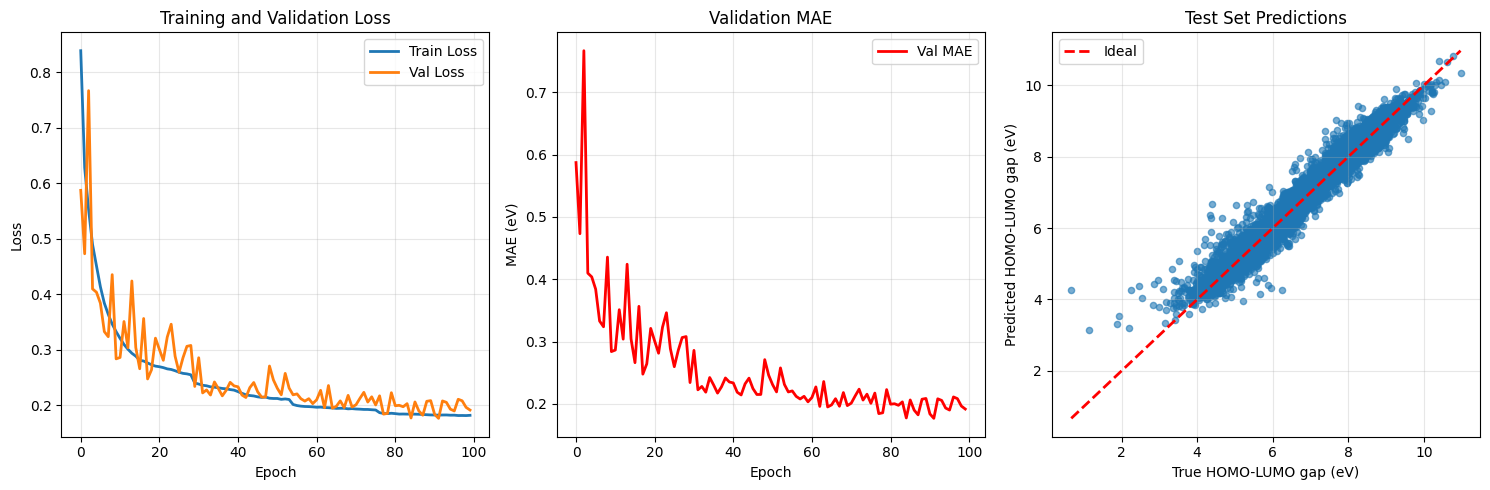

In [ ]:
import torch.nn.functional as F
from egnn_pytorch import EGNN_Network

class QM9_EGNN_Model(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=4):
        super().__init__()
        self.hidden_dim = hidden_dim

        # EGNN_Network для обработки графов QM9
        self.egnn = EGNN_Network(
            num_tokens = 5,
            dim = hidden_dim,
            depth = num_layers,
            edge_dim = 4,
            num_nearest_neighbors = 0,
            only_sparse_neighbors = True,
            norm_coors = True,
            dropout = 0.1,
            coor_weights_clamp_value = 2.0
        )

        # регрессор для HOMO-LUMO gap
        self.regression = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, 1)
        )

    def atom_numbers_to_indices(self, z):
        """Конвертирует атомные номера в индексы 0-4"""
        mapping = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}
        indices = torch.zeros_like(z, dtype=torch.long)
        for orig, idx in mapping.items():
            mask = z == orig
            if mask.any():
                indices[mask] = idx
        return indices

    def prepare_batch_data(self, batch):
        """Подготавливает данные для batch обработки в EGNN_Network"""
        # Атомные индексы
        atom_indices = self.atom_numbers_to_indices(batch.z)

        # Координаты
        coors = batch.pos  # [total_nodes, 3]

        # Определяем batch информацию
        if hasattr(batch, 'batch'):
            batch_indices = batch.batch
            batch_size = int(batch_indices.max().item()) + 1

            # Находим максимальное количество узлов в batch
            batch_counts = torch.bincount(batch_indices)
            max_nodes = int(batch_counts.max().item())

            # Создаём padded тензоры
            padded_atom_indices = torch.zeros(batch_size, max_nodes, dtype=torch.long, device=atom_indices.device)
            padded_coors = torch.zeros(batch_size, max_nodes, 3, device=coors.device)
            padded_mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool, device=atom_indices.device)

            # Создаём adjacency матрицу (bool)
            adj_mat = torch.zeros(batch_size, max_nodes, max_nodes, dtype=torch.bool, device=atom_indices.device)

            # Создаём edge features если есть
            if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                edge_dim = batch.edge_attr.shape[1]
                edges = torch.zeros(batch_size, max_nodes, max_nodes, edge_dim, device=coors.device)
            else:
                edges = None

            # Заполняем padded тензоры для каждого графа
            node_offsets = torch.zeros(batch_size + 1, dtype=torch.long, device=atom_indices.device)
            for i in range(1, batch_size + 1):
                node_offsets[i] = node_offsets[i-1] + batch_counts[i-1]

            for i in range(batch_size):
                start_idx = node_offsets[i]
                end_idx = node_offsets[i+1]
                num_nodes_i = end_idx - start_idx

                # Заполняем atom indices и координаты
                padded_atom_indices[i, :num_nodes_i] = atom_indices[start_idx:end_idx]
                padded_coors[i, :num_nodes_i] = coors[start_idx:end_idx]
                padded_mask[i, :num_nodes_i] = True

                # Обрабатываем рёбра этого графа
                if batch.edge_index.shape[1] > 0:
                    # Фильтруем рёбра для этого графа
                    edge_mask = (batch_indices[batch.edge_index[0]] == i) & (batch_indices[batch.edge_index[1]] == i)
                    graph_edges = batch.edge_index[:, edge_mask]

                    if graph_edges.shape[1] > 0:
                        # Конвертируем глобальные индексы в локальные
                        local_edges = graph_edges - start_idx

                        # Заполняем adjacency матрицу
                        adj_mat[i, local_edges[0], local_edges[1]] = True

                        # Заполняем edge features если есть
                        if edges is not None:
                            graph_edge_attr = batch.edge_attr[edge_mask]
                            edges[i, local_edges[0], local_edges[1]] = graph_edge_attr

            return {
                'atom_indices': padded_atom_indices,
                'coors': padded_coors,
                'mask': padded_mask,
                'adj_mat': adj_mat,
                'edges': edges,
                'batch_size': batch_size,
                'batch_counts': batch_counts,
                'node_offsets': node_offsets
            }

        else:
            # Single graph
            num_nodes = atom_indices.shape[0]
            atom_indices = atom_indices.unsqueeze(0)
            coors = coors.unsqueeze(0)
            mask = torch.ones_like(atom_indices, dtype=torch.bool)

            # Создаём adjacency матрицу
            adj_mat = torch.zeros(1, num_nodes, num_nodes, dtype=torch.bool, device=atom_indices.device)

            # Заполняем adjacency матрицу
            for edge_idx in range(batch.edge_index.shape[1]):
                src, dst = batch.edge_index[:, edge_idx]
                adj_mat[0, src, dst] = True

            # Edge features
            if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                edge_dim = batch.edge_attr.shape[1]
                edges = torch.zeros(1, num_nodes, num_nodes, edge_dim, device=coors.device)
                for edge_idx in range(batch.edge_index.shape[1]):
                    src, dst = batch.edge_index[:, edge_idx]
                    edges[0, src, dst] = batch.edge_attr[edge_idx]
            else:
                edges = None

            return {
                'atom_indices': atom_indices,
                'coors': coors,
                'mask': mask,
                'adj_mat': adj_mat,
                'edges': edges,
                'batch_size': 1,
                'batch_counts': torch.tensor([num_nodes], device=atom_indices.device),
                'node_offsets': torch.tensor([0, num_nodes], device=atom_indices.device)
            }

    def forward(self, batch):
        # Подготавливаем batch данные
        batch_data = self.prepare_batch_data(batch)

        # Извлекаем подготовленные данные
        atom_indices = batch_data['atom_indices']
        coors = batch_data['coors']
        mask = batch_data['mask']
        adj_mat = batch_data['adj_mat']
        edges = batch_data['edges']
        batch_size = batch_data['batch_size']
        batch_counts = batch_data['batch_counts']

        # Прямой проход через EGNN_Network
        if edges is not None:
            feats_out, coors_out = self.egnn(
                atom_indices,
                coors,
                mask = mask,
                adj_mat = adj_mat,
                edges = edges
            )
        else:
            feats_out, coors_out = self.egnn(
                atom_indices,
                coors,
                mask = mask,
                adj_mat = adj_mat
            )

        # Извлекаем features для каждого графа
        pooled_features = []

        for i in range(batch_size):
            num_nodes_i = batch_counts[i]
            if num_nodes_i > 0:
                # Берем только валидные узлы (не padded)
                graph_feats = feats_out[i, :num_nodes_i]

                # Mean pooling по узлам графа
                graph_pooled = graph_feats.mean(dim=0, keepdim=True)
                pooled_features.append(graph_pooled)

        # Объединяем все графы
        if pooled_features:
            all_pooled = torch.cat(pooled_features, dim=0)
        else:
            all_pooled = torch.zeros(batch_size, self.hidden_dim, device=feats_out.device)

        # Финальная регрессия
        return self.regression(all_pooled).squeeze(-1)

# Функции обучения
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in data_loader:
        batch = batch.to(device)
        targets = batch.y  # HOMO-LUMO gap

        optimizer.zero_grad()
        predictions = model(batch)
        loss = criterion(predictions, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(data_loader.dataset)

def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_mae = 0

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            targets = batch.y
            predictions = model(batch)

            loss = criterion(predictions, targets)
            mae = F.l1_loss(predictions, targets)

            total_loss += loss.item() * batch.num_graphs
            total_mae += mae.item() * batch.num_graphs

    return total_loss / len(data_loader.dataset), total_mae / len(data_loader.dataset)

# Инициализация и обучение
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QM9_EGNN_Model(hidden_dim=128, num_layers=4).to(device)

print("QM9 EGNN Model Initialized")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Проверка на одном batch
print("\nTesting model on one batch...")
test_batch = next(iter(train_loader))
test_batch = test_batch.to(device)
with torch.no_grad():
    output = model(test_batch)
    print(f"Input batch size: {test_batch.num_graphs}")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {test_batch.y.shape}")
    print(f"Sample predictions: {output[:5].cpu().numpy()}")
    print(f"Sample targets: {test_batch.y[:5].cpu().numpy()}")

# Настройка обучения
learning_rate = 1e-3
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = nn.L1Loss()

# Переменные для отслеживания
best_val_mae = float('inf')
best_model_path = 'best_qm9_egnn_model.pt'

train_losses, val_losses, val_maes = [], [], []

print(f"\nStarting training for {n_epochs} epochs...")

for epoch in range(1, n_epochs + 1):
    # Обучение
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Валидация
    val_loss, val_mae = evaluate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae:.4f} eV")

    # Сохранение лучшей модели
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_mae': val_mae,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"  → New best model saved! Val MAE: {val_mae:.4f} eV")

print(f"\nTraining completed! Best Val MAE: {best_val_mae:.4f} eV")

# Тестирование
print("\nTesting best model...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_mae = evaluate_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f} eV")

# Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# 1. Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Validation MAE
plt.subplot(1, 3, 2)
plt.plot(val_maes, label='Val MAE', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE (eV)')
plt.title('Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions vs Targets на тестовом наборе
plt.subplot(1, 3, 3)
test_predictions = []
test_targets = []

model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        predictions = model(batch)
        targets = batch.y
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(batch.y.cpu().numpy())
        if batch_idx == 0:
            print(f"Первые 5 предсказаний из батча {batch_idx}:")
            print(f"  Predictions: {predictions[:5].cpu().numpy()}")
            print(f"  Targets:     {targets[:5].cpu().numpy()}")

    test_predictions = np.array(test_predictions)
    test_targets = np.array(test_targets)

    # MAE
    mae = np.mean(np.abs(test_predictions - test_targets))
    # RMSE
    rmse = np.sqrt(np.mean((test_predictions - test_targets) ** 2))
    # R²
    ss_res = np.sum((test_targets - test_predictions) ** 2)
    ss_tot = np.sum((test_targets - np.mean(test_targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    print(f"MAE:  {mae:.4f} эВ")
    print(f"RMSE: {rmse:.4f} эВ")
    print(f"R²:   {r2:.4f}")

plt.scatter(test_targets, test_predictions, alpha=0.6, s=20)
min_val = min(min(test_targets), min(test_predictions))
max_val = max(max(test_targets), max(test_predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal', linewidth=2)
plt.xlabel('True HOMO-LUMO gap (eV)')
plt.ylabel('Predicted HOMO-LUMO gap (eV)')
plt.title('Test Set Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# def analyze_difficult_cases(df, model_predictions):
#     """Анализ молекул, которые модель предсказывает плохо"""

#     # Вычисляем ошибки
#     df['prediction_error'] = abs(df['homo_lumo_gap'] - model_predictions)

#     # Находим 5% самых сложных случаев
#     threshold = df['prediction_error'].quantile(0.95)
#     difficult_cases = df[df['prediction_error'] > threshold]

#     print(f"Самые сложные 5% случаев (ошибка > {threshold:.3f} эВ):")
#     print(f"  Количество: {len(difficult_cases)} молекул")
#     print(f"  Средняя ошибка: {difficult_cases['prediction_error'].mean():.3f} эВ")

#     # Анализ характеристик сложных случаев
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#     # 1. Распределение по химическим классам
#     difficult_cases['chem_class'].value_counts().plot.pie(ax=axes[0,0])
#     axes[0,0].set_title('Сложные случаи: химические классы')

#     # 2. Распределение по размеру
#     axes[0,1].hist(difficult_cases['total_atoms'], bins=30)
#     axes[0,1].set_title('Сложные случаи: размер молекул')

#     # 3. Ошибка vs размер
#     axes[0,2].scatter(df['total_atoms'], df['prediction_error'], alpha=0.3)
#     axes[0,2].scatter(difficult_cases['total_atoms'],
#                       difficult_cases['prediction_error'],
#                       color='red', label='Сложные случаи')
#     axes[0,2].set_xlabel('Число атомов')
#     axes[0,2].set_ylabel('Ошибка (эВ)')
#     axes[0,2].legend()

#     # 4. Ошибка vs gap
#     axes[1,0].scatter(df['homo_lumo_gap'], df['prediction_error'], alpha=0.3)
#     axes[1,0].scatter(difficult_cases['homo_lumo_gap'],
#                       difficult_cases['prediction_error'],
#                       color='red')
#     axes[1,0].set_xlabel('HOMO-LUMO gap (эВ)')
#     axes[1,0].set_ylabel('Ошибка (эВ)')

#     # 5. UMAP сложных случаев
#     if 'umap_x' in df.columns:
#         axes[1,1].scatter(df['umap_x'], df['umap_y'],
#                          c=df['prediction_error'],
#                          cmap='viridis', alpha=0.3, s=10)
#         axes[1,1].scatter(difficult_cases['umap_x'],
#                          difficult_cases['umap_y'],
#                          color='red', s=30, label='Сложные')
#         axes[1,1].set_title('Сложные случаи на UMAP')
#         axes[1,1].legend()

#     plt.tight_layout()
#     plt.show()